In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 准备数据集

我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：  
May I borrow this book? ¿Puedo tomar prestado este libro?


下载完毕数据集之后，我们需要做如下步骤：
1. 给每一个句子添加一个开始与结束标记（token）
2. 删除特殊字符以清理句子
3. 创建一个单词索引与一个反向单词索引（word2idx，idx2word）
4. 将每一个句子填充到最大长度（padding）

In [2]:
# 加载文件路径
path_to_file='语料库/spa-eng/spa.txt'

In [3]:
# 将unicode转为ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!="Mn")

In [4]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentences=u'I played basketball yesterday.'
sp_sentences=u'Ayer jugué al baloncesto.'
print(preprocess_sentence(en_sentences))
print(preprocess_sentence(sp_sentences))

<start> i played basketball yesterday . <end>
<start> ayer jugue al baloncesto . <end>


In [6]:
# 去除重音符号,如jugué 的 é 变为jugue
# 清理句子
# 返回单词对【English，Spanish，_(无用的信息）】
def create_dataset(path,num_examples):
    lines=io.open(path,encoding='UTF-8').read().strip().split('\n')
    word_pairs=[[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:min(num_examples,len(lines)-1) if num_examples else None]]
    return zip(*word_pairs)

In [7]:
x=[1,2,3]
y=[4,5,6]
z=[7,8,9]

w= zip(x,y,z)#[(1, 4, 7), (2, 5, 8), (3, 6, 9)]

# zip() in conjunction with the * operator can be used to unzip a list:
zip(*w) #[(1, 2, 3), (4, 5, 6), (7, 8, 9)]



In [8]:
# create_dataset将list中的元素拆分为三份返回
# en是第一个英文数据，sp是第二个西班牙文数据，第三个数据是后面不用管的
en, sp,_ = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboracion . sin embargo , si animamos a los miembros a contribuir frases en sus propios idiomas en lugar de experimentar con los idiomas que estan aprendiendo , podriamos ser capaces de minimizar los errores . <end>


In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
# tf.keras.preprocessing.text.Tokenizer:
# 此类允许通过将每个文本转换成整数序列（每个整数是字典中标记的索引）或转换成矢量（其中每个标记的系数可以是二进制的）的矢量化语料库，基于单词数 ，基于tf-idf ...

# filters: a string where each element is a character that will be
#          filtered from the texts. The default is all punctuation, plus
#          tabs and line breaks, minus the `'` character.
def tokenize(lang):
    lang_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='')
#     fit_on_texts:
#     根据文本列表更新内部词汇。 在文本包含列表的情况下，我们假定列表的每个条目都是一个标记。 在使用texts_to_sequences或texts_to_matrix之前是必需的。
    lang_tokenizer.fit_on_texts(lang)
    # text_to_sequences:
    # Transforms each text in texts to a sequence of integers.
    # 只考虑前num_words-1词频的词，只考虑分词器已知的词

    tensor=lang_tokenizer.texts_to_sequences(lang)
    tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor,lang_tokenizer

In [11]:
def load_dataset(path,num_examples=None):
    # create_dataset 返回单词对【English，Spanish，_(无用的信息）】
    target_lang,input_lang,_=create_dataset(path,num_examples)
    input_tensor,input_lang_tokenizer=tokenize(input_lang)
    target_tensor,target_lang_tokenizer=tokenize(target_lang)
    return input_tensor,input_lang_tokenizer,target_tensor,target_lang_tokenizer

### 选择训练集大小

In [19]:
# 注意，训练集一共有123335条语句，并且训练集后面的语句更长
# 所以训练集较小，对于较短的语句效果较好
# 使用num_examples=None 即使用所有训练语句
num_examples=30000 # 训练数据集大小
input_tensor,input_lang_tokenizer,target_tensor,target_lang_tokenizer=\
load_dataset(path_to_file,num_examples)

In [39]:
# 在tokenizer.index_word字典中，包含了我们所有的词索引
target_lang_tokenizer.word_index['love'],target_lang_tokenizer.index_word[49]

(73, 'very')

In [20]:
# 计算句子最大长度
max_length_input,max_length_target=max_length(input_tensor),max_length(target_tensor)
max_length_input,max_length_target

(16, 11)

In [22]:
input_tensor.shape,target_tensor.shape

((30000, 16), (30000, 11))

In [25]:
# 切分训练集与验证集
input_tensor_train,input_tensor_val,target_tensor_train,target_tensor_val=\
train_test_split(input_tensor,target_tensor,test_size=0.2)
print(len(input_tensor_train),len(input_tensor_val))

24000 6000


In [43]:
def convert(lang_tokenizer,tensor):
    for t in tensor:
        if t!=0:
            print('{} ---> {}'.format(t,lang_tokenizer.index_word[t]))

In [46]:
print("input language:index to word")
convert(input_lang_tokenizer,input_tensor_train[23])
print('target language:index to word')
convert(target_lang_tokenizer,target_tensor_train[23])

input language:index to word
1 ---> <start>
17 ---> se
47 ---> estaba
7901 ---> oscureciendo
3 ---> .
2 ---> <end>
target language:index to word
1 ---> <start>
9 ---> it
26 ---> was
349 ---> getting
554 ---> dark
3 ---> .
2 ---> <end>


In [88]:
# 使用tf.data创建数据集
Buffer_size=len(input_tensor_train)
Batch_size=64
steps_per_epoch=len(input_tensor_train)//Batch_size
embedding_dim=256
units=1024
# 加一是因为用了padding（0）
vocab_input_size=len(input_lang_tokenizer.word_index)+1
vocab_target_size=len(target_lang_tokenizer.word_index)+1
dataset=tf.data.Dataset.from_tensor_slices((input_tensor_train,target_tensor_train)).shuffle(Buffer_size)
# 最后形成不了一个batch的丢弃  drop_remainder
dataset=dataset.batch(Batch_size,drop_remainder=True)



In [48]:
example_input_batch,example_target_batch=next(iter(dataset))
example_input_batch.shape,example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 创建encoder与decoder

使用的是Bahdanau注意力模型
![img](./pic/attention1.png)
论文中底层使用双向RNN（这里使用的单向GRU）


模型公式如下定义：
- FC = 完全连接（密集）层
- EO = 编码器输出
- H = 解码器隐藏层状态
- X = 解码器输入.对应于翻译目标在该时间步的tensor，经过嵌入层之后变为输入词的嵌入词向量

- score=FC(tanh(Fc(EO)+(FC(H)))
- attention weights=softmax(score,axis=1).注意axis=1。因为softmax默认计算最后一个轴。 因为分数 （score） 的形状是 (批大小，最大长度，1)。最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
- context vector = sum(attention weights * EO, axis = 1)
- embedding output = 解码器输入 X 通过一个嵌入层。
- merged vector = concat(embedding output, context vector)

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_dim,encoder_units,batch_size):
        super(Encoder,self).__init__()
        self.batch_size=batch_size
        self.encoder_units=encoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru=tf.keras.layers.GRU(self.encoder_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    
    def call(self,x,hidden):
        x=self.embedding(x)
        output,state=self.gru(x,initial_state=hidden)
        return output,state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size,self.encoder_units))
        

In [56]:
encoder=Encoder(vocab_input_size,embedding_dim,units,Batch_size)
# 样本输入
sample_hidden=encoder.initialize_hidden_state()
sample_output,sample_hidden=encoder(example_input_batch,sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [71]:
a=tf.Variable([[[1,1],[2,2],[3,1]]])
a=tf.cast(a,tf.float32)
print(a.shape)
print(tf.nn.softmax(a,axis=1))
print(tf.nn.softmax(a,axis=2))

(1, 3, 2)
tf.Tensor(
[[[0.09003057 0.21194157]
  [0.24472848 0.5761169 ]
  [0.66524094 0.21194157]]], shape=(1, 3, 2), dtype=float32)
tf.Tensor(
[[[0.5        0.5       ]
  [0.5        0.5       ]
  [0.880797   0.11920291]]], shape=(1, 3, 2), dtype=float32)


In [161]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(Attention,self).__init__()
        self.W1=tf.keras.layers.Dense(units)
        self.W2=tf.keras.layers.Dense(units)
        self.V=tf.keras.layers.Dense(1)
    def call(self,query,values):
        # query是decoder隐藏层状态，values是encoder的输出
        # 使用的 decoder的hidden-state和output计算score
        
        # hidden_state.shape=(batch_size,units)
        # hidden_state_with_time_axis.shape=(batch_size,1,units)
        # 这样方便执行加法计算分数
        hidden_state_with_time_axis=tf.expand_dims(query,1)
        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，units(设置在init函数中））
        score=self.V(tf.nn.tanh(self.W1(values)+ self.W2(hidden_state_with_time_axis)))
        
        # attention_weights.shape = （批大小，最大长度，1）
        # 注意是axis=1 在第二个维度上
        attention_weights=tf.nn.softmax(score,axis=1)
        
        # contect_vector.shape=(批大小，隐藏层大小）
        context_vector=tf.reduce_sum(attention_weights*values,axis=1)
        
        return context_vector,attention_weights

In [162]:
attention_layer = Attention(10)
attention_vector, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [163]:
class Decoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_dim,decoder_units,batch_size):
        super(Decoder,self).__init__()
        self.batch_size=batch_size
        self.decoder_units=decoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru=tf.keras.layers.GRU(self.decoder_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc=tf.keras.layers.Dense(vocab_size)
        
        self.attention=Attention(self.decoder_units)
        
    def call(self,x,hidden_state,encoder_output):
        # 这个参数x是decoder的输入，对应每一个时间步的翻译目标值
        # hidden代表的是decoder自己的hidden-state
        # decoder-hidden-state与encoder-output两个向量迎来计算出得分，从而获得attention-weights
        
        # encoder_output.shape=(批大小，最大长度，隐藏层大小)
        context_vector, attention_weights=self.attention(hidden_state,encoder_output)
        # x是上层解码器的输入，通过嵌入层之后维度为（批大小，1，嵌入维度）
        x=self.embedding(x)
        
        # x进行拼接（concatenation）之后shape为（批大小，1，嵌入维度+隐藏层大小）
        # context_vector.shape=(batch_size,units)
        x=tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        
        # 将合并后的向量传到解码器的GRU
        output,state=self.gru(x)
        
        # 输出的形状(reshape前）=(批大小，1,隐藏层大小)
        # 输出的形状(reshape后）=(批大小,隐藏层大小)
        output=tf.reshape(output,(-1,output.shape[2]))
        
        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

In [164]:
decoder = Decoder(vocab_target_size, embedding_dim, units, Batch_size)

sample_decoder_output, a, b = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print(a.shape,b.shape)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 1024) (64, 16, 1)
Decoder output shape: (batch_size, vocab size) (64, 4834)


### 定义优化器，损失函数

In [165]:
optimizer=tf.keras.optimizers.Adam()
# y_true: Ground truth values. shape = [batch_size, d0, .. dN]
# y_pred: The predicted values. shape = [batch_size, d0, .. dN]
# recuction=none，那么返回的损失是[batch_size, d0, .. dN-1]（(Note dN-1 because all loss functions reduce by 1 dimension, usually axis=-1.)）
# 否则返回的损失是一个常量，
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(y_true,y_pred):
    # 标记出来padding 0 所在的位置下标
    # 最后在与loss相乘的时候省略padding位置所产生的loss
    mask=tf.math.logical_not(tf.math.equal(y_true,0))
    loss=loss_object(y_true,y_pred)
    mask=tf.cast(mask,dtype=loss.dtype)
    loss*=mask
    return tf.reduce_mean(loss)

### 检查点

In [166]:
checkpoint_dir='./machine_translation_checkpoint'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(optimizer=optimizer,
                              encoder=encoder,
                              decoder=decoder)


## 训练

1. 将 输入 传送至 编码器，编码器返回 编码器输出 和 编码器隐藏层状态。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 开始标记）传送至解码器。
3. 解码器返回 预测 和 解码器隐藏层状态。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 教师强制 （teacher forcing） 决定解码器的下一/个输入。
6. 教师强制 是将 目标词 作为 下一个输入 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [97]:
tf.expand_dims(tf.random.normal((64,16)),1).shape

TensorShape([64, 1, 16])

In [111]:
@tf.function
def train_step(inp,targ,enc_hidden):
    loss=0
    
    with tf.GradientTape() as tape:
        enc_output,enc_hidden=encoder(inp,enc_hidden)
        
        # 在第一步，decoder-hidden=encoder-hidden老初始化
        # 之后，decode-hidden就在每一次解码中更新了
        dec_hidden=enc_hidden
        
        dec_input=tf.expand_dims([target_lang_tokenizer.word_index['<start>']]*Batch_size,1)
        
        # 教师强制-将目标词作为下一个输入
        for t in range(1,targ.shape[1]):
            # 将编码器输出传到解码器
            predictions,dec_hidden,_=decoder(dec_input,dec_hidden,enc_output)
            
            loss+=loss_function(targ[:,t],predictions)
            
            # 使用教师强制
            dec_input=tf.expand_dims(targ[:,t],1)
        
        batch_loss=(loss/int(targ.shape[1]))
        
        variables=encoder.trainable_variables+decoder.trainable_variables

        # 对每一个变量计算梯度
        gradients=tape.gradient(loss,variables)
        
        # Apply gradients to variables
        optimizer.apply_gradients(zip(gradients,variables))
        return batch_loss
            

In [110]:
EPOCHS=10
for epoch in range(EPOCHS):
    start=time.time()
    
    enc_hidden=encoder.initialize_hidden_state()
    
    total_loss=0
    
    for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss=train_step(inp,targ,enc_hidden)
        total_loss+=batch_loss
     
        if batch%100==0:
            print(f'Epoch {epoch+1} Batch {batch} loss: {batch_loss.numpy()}')
        # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss: 3.029433488845825
Epoch 1 Batch 100 loss: 2.1914610862731934
Epoch 1 Batch 200 loss: 1.7751097679138184
Epoch 1 Batch 300 loss: 1.5683094263076782
Epoch 1 Loss 1.9404
Time taken for 1 epoch 428.19849133491516 sec

Epoch 2 Batch 0 loss: 1.5071711540222168
Epoch 2 Batch 100 loss: 1.511332631111145
Epoch 2 Batch 200 loss: 1.4215682744979858
Epoch 2 Batch 300 loss: 1.1929481029510498
Epoch 2 Loss 1.3614
Time taken for 1 epoch 412.7278311252594 sec

Epoch 3 Batch 0 loss: 1.0165706872940063
Epoch 3 Batch 100 loss: 0.9832627177238464
Epoch 3 Batch 200 loss: 0.970638632774353
Epoch 3 Batch 300 loss: 0.8129992485046387
Epoch 3 Loss 0.9585
Time taken for 1 epoch 409.06610584259033 sec

Epoch 4 Batch 0 loss: 0.654787540435791
Epoch 4 Batch 100 loss: 0.635719895362854
Epoch 4 Batch 200 loss: 0.7151980400085449
Epoch 4 Batch 300 loss: 0.6077576279640198
Epoch 4 Loss 0.6469
Time taken for 1 epoch 413.9337651729584 sec

Epoch 5 Batch 0 loss: 0.41980913281440735
Epoch 5 Batch 100

# 翻译

- 翻译的时候类似于循环训练，但是我们不使用教师强制（teaching force）来将正确的目标推送到解码器。每个时间步的解码器输入是之前的预测，隐藏层状态与编码器输出
- 当模型预测到结束标记（< end >)的时候停止输出
- 我们需要存储每一个时间步的attention weights，方便绘制图像

In [177]:
def evaluate(sentence):
    attention_plot=np.zeros((max_length_target,max_length_input))
    # preprocess_sentence
    # 在单词符号之间插入空格
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    sentence=preprocess_sentence(sentence)
    
    # 将输入文本转为数字编码
    inputs=[input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    # 对输入进行pudding
    inputs=tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_input,padding='post')
    
    # 可以将tf常量，数组，numpy数组转为tensor
    inputs=tf.convert_to_tensor(inputs)
    
    result=''
    
    enc_hidden=tf.zeros((1,units))
    
    enc_output,enc_hidden=encoder(inputs,enc_hidden)
    
    dec_hidden=enc_hidden
    # 添加一个维度，变为（1，1）
    dec_input=tf.expand_dims([target_lang_tokenizer.word_index['<start>']],0)
    
    
    for t in range(max_length_target):
        predictions,dec_hidden,attention_weights=decoder(dec_input,dec_hidden,enc_output)
        
        # 存储注意力权重，从而进行绘图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t]=attention_weights.numpy()
        
        predicted_index=tf.argmax(predictions[0]).numpy()
        result+=target_lang_tokenizer.index_word[predicted_index]+' '
        
        if target_lang_tokenizer.index_word[predicted_index] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_index], 0)

    return result, sentence, attention_plot

In [217]:
# 绘制注意力权重图
def plot_attention(attention_plot,sentence,predicted_sentence):
    fig=plt.figure(figsize=(3,3))
    ax=fig.add_subplot(1,1,1)
    ax.matshow(attention_plot,cmap='viridis')
    
    fontdict={'fontsize':14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [218]:
def translate(sentence):
    # attention-plot维度是 （max_length_target，max-length-input）
    result,sentence,attention_plot=evaluate(sentence)
    
    print(f'Input is: {sentence}')
    print(f' My Translation is: {result}')
    
    # 截去没有用的维度，
    attention_plot=attention_plot[:len(result.split(' ')),:len(sentence.split(' '))]
    
    plot_attention(attention_plot,sentence.split(' '),result.split(' '))

## 从检查点恢复模型

In [219]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Googole translation: It's cold outside.
Input is: <start> hace frio afuera . <end>
 My Translation is: it s cold outside . <end> 


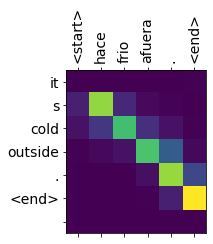

In [220]:
print("Googole translation: It's cold outside.")
translate('Hace frío afuera.')

Input is: <start> ¿ todavia estan en casa ? <end>
 My Translation is: are you still at home ? <end> 


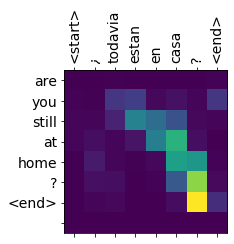

In [221]:
print("Googole translation: are you still at home ?")
translate('¿ todavia estan en casa ? ')

Googole translation: because the virus I can't go out
Input is: <start> no puedo salir porque el virus <end>
 My Translation is: i can t go anywhere . <end> 


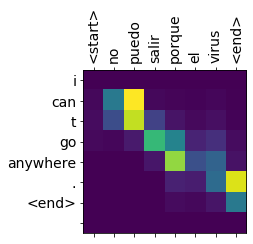

In [226]:
print("Googole translation: because the virus I can't go out")
translate('No puedo salir porque el virus')